In [63]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Loading The Imbalanced Data

In [30]:
data_path1=r"data\imbalanced_data.csv"
data1=pd.read_csv(data_path1)

In [31]:
data1.head() 

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


- if label is 0 then it is not hate speech
- if label is 1 then it is hate speech

In [32]:
data1.drop(columns=['id'],inplace=True) #dropping id column

### Plot Some Graphs , To understand The Data

In [33]:
data1.value_counts('label') #checking the distribution of labels

label
0    29720
1     2242
Name: count, dtype: int64

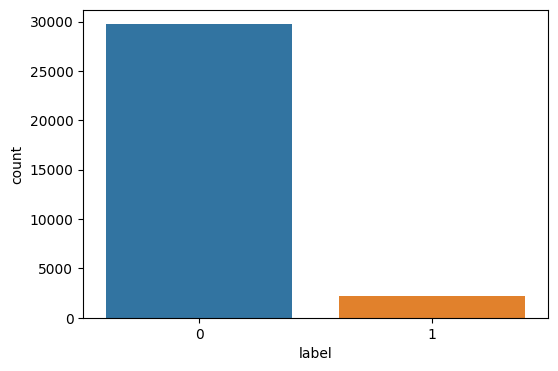

In [34]:
figure = plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data1) #plotting the count of each label
plt.show()

### Loading The Raw Data

In [35]:

data_path2=r"data\raw_data.csv"
data2=pd.read_csv(data_path2)

In [36]:
data2.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [37]:
data2=data2[['class','tweet']] #selecting only the required columns
data2.columns=['label','tweet'] # renaming the columns

class label for majority of CF users. 

0 - hate speech 

1 - offensive language 

2 - neither

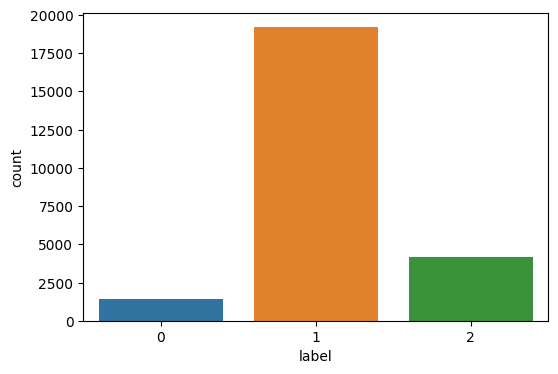

In [38]:
figure = plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data2) #plotting the count of each label
plt.show()

I need to simplify the labels to 0 and 1

- 0 - hate speech  and 1 - offensive language  are similar  so i will combine them into 1
- neither is fine as    0


In [39]:
data2['label']=data2['label'].replace(0,1) #replacing 0 with 1
data2['label']=data2['label'].replace(2,0) #replacing 2 with 0

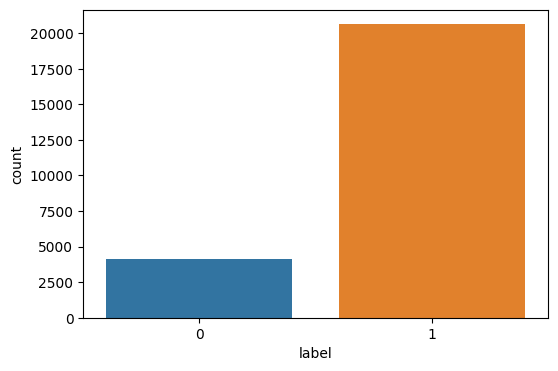

In [40]:
figure = plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data2) #plotting the count of each label
plt.show()

# concatenating both the datasets

In [41]:

data=pd.concat([data1,data2],ignore_index=True)

In [42]:
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [43]:
data.describe()

,label
count,56745.000000
mean,0.402890
std,0.490483
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


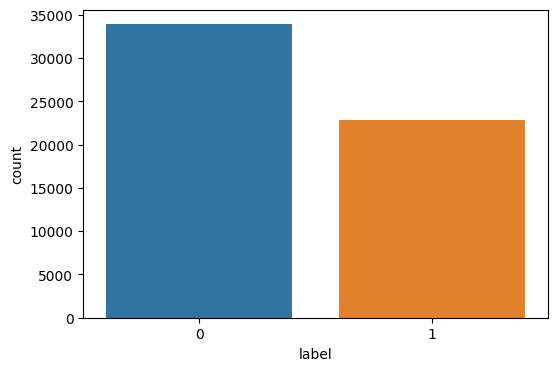

In [44]:
figure = plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data) #plotting the count of each label
plt.show()
# now the data is balanced

In [45]:
data.shape

(56745, 2)

### Text Preprocessing

In [46]:
# Shuffle the dataframe
df = data.sample(frac=1, random_state=42)

In [47]:
df.head()

,label,tweet
44200,1,Kim K is alright but honestly so many niggas b...
46339,0,RT @BigJonBul: The stars wink knowingly and sm...
49169,1,RT @Sassymermaidxo: &#8220;@VSamone: &#8220;@Z...
54130,1,"Those ""tell me about yourself "" lookin ass nig..."
18801,0,4 days ago ... to celebrate #national iced tea...


In [48]:
#stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(text):
    text = text.split()
    words = [stemmer.stem(word) for word in text]
    return " ".join(words)



In [50]:
# removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

def remove_stopwords(text):
    text = text.split()
    words = [word for word in text if word not in stop]
    return " ".join(words)



In [51]:
# removing punctuations
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text



In [52]:
# removing urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)



In [53]:
# lemmitization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmitization(text):
    text = text.split()
    words = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(words)




In [55]:
# combining all the above steps
def clean_text(text):
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_stopwords(text)
    text = remove_urls(text)
    text = stemming(text)
    text = lemmitization(text)
    return text

df['tweet'] = df['tweet'].apply(clean_text)

In [58]:
data["tweet"][0] #original tweet

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [57]:
df['tweet'][0] #cleaned tweet

'user father dysfunct selfish drag kid dysfunct run'

In [59]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45396,), (11349,), (45396,), (11349,))

In [65]:
# Tokenization
max_words = 100000
max_len = 400
tok = Tokenizer(num_words=max_words) #defining tokenizer with maximum number of words as 100000 
tok.fit_on_texts(X_train) #fitting tokenizer on train data

sequences = tok.texts_to_sequences(X_train) #converting text to sequences
sequences_matrix = pad_sequences(sequences, maxlen=max_len) #To make all the sequences of same length

In [66]:
sequences_matrix

array([[    0,     0,     0, ...,   390,  2379, 17484],
       [    0,     0,     0, ...,   299,     6,  8387],
       [    0,     0,     0, ...,   759,   333,  1426],
       ...,
       [    0,     0,     0, ...,   176,   916,  1103],
       [    0,     0,     0, ...,     5,   636,     2],
       [    0,     0,     0, ...,    56,  4775, 59448]])

In [67]:
sequences_matrix.shape

(45396, 400)

In [68]:
# inlitializing the model for LSTM

model = Sequential()
#This is a sequential model

model.add(Embedding(max_words, 128, input_length=max_len)) #embedding layer 
# this embedding layer will take the input of maximum 100000 words and convert it into 128 dimensional vector

model.add(SpatialDropout1D(0.4)) #dropout layer
# this dropout layer will drop 40% of the neurons

model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2)) #LSTM layer
# this LSTM layer will have 196 neurons and will drop 20% of the neurons
# defference between dropout and recurrent_dropout 
# dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
# recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.

model.add(Dense(1, activation='sigmoid')) #output layer
# this output layer will have 1 neuron and will have sigmoid activation function

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #compiling the model
# loss function is binary_crossentropy and optimizer is adam
# metrics is accuracy
# this is a binary classification problem so we are using binary_crossentropy as loss function
# if it was a multi class classification problem then we would have used categorical_crossentropy as loss function


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 128)          12800000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 400, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 1)                 197       
                                                                 
Total params: 13,054,997
Trainable params: 13,054,997
Non-trainable params: 0
_________________________________________________________________


In [70]:
# fitting the model
model.fit(sequences_matrix, y_train, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5


568/568 [==============================] - 2054s 4s/step - loss: 0.2313 - accuracy: 0.9151 - val_loss: 0.1477 - val_accuracy: 0.9480
Epoch 2/5
568/568 [==============================] - 2063s 4s/step - loss: 0.0993 - accuracy: 0.9657 - val_loss: 0.1482 - val_accuracy: 0.9518
Epoch 3/5
568/568 [==============================] - 2267s 4s/step - loss: 0.0585 - accuracy: 0.9811 - val_loss: 0.1653 - val_accuracy: 0.9489
Epoch 4/5
568/568 [==============================] - 2286s 4s/step - loss: 0.0384 - accuracy: 0.9877 - val_loss: 0.1970 - val_accuracy: 0.9430
Epoch 5/5
568/568 [==============================] - 2010s 4s/step - loss: 0.0257 - accuracy: 0.9925 - val_loss: 0.2264 - val_accuracy: 0.9343


In [71]:
# converting test data into sequences
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)



In [72]:
model.evaluate(test_sequences_matrix,y_test) #evaluating the model

355/355 [==============================] - 80s 225ms/step - loss: 0.2531 - accuracy: 0.9323


[0.2530578076839447, 0.9323288202285767]

In [73]:
# predicting the test data
y_pred=model.predict(test_sequences_matrix)
# converting the predicted  if the value is greater than 0.5 then it will be 1 else 0
y_pred=np.where(y_pred>0.5,1,0)


355/355 [==============================] - 141s 391ms/step


<Axes: >

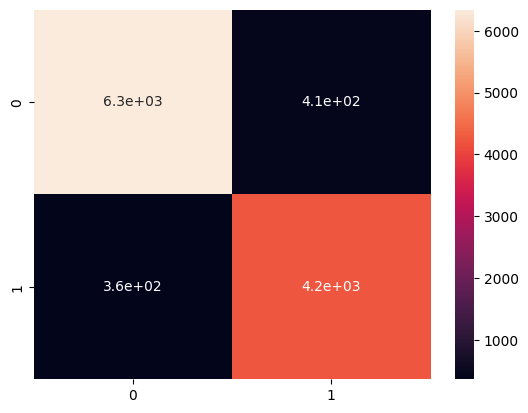

In [74]:
# plotting the confusion matrix
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True)

# plotting the classification report

In [75]:
# picking tokenizer and model
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('model.h5')
